In [6]:
import os
import pandas as pd

# Load dataset
dataset_folder = os.path.join('datasets')
dataset_path = os.path.join(dataset_folder, 'yelpzip.csv')
dataset = pd.read_csv(dataset_path)
dataset['review'].fillna('', inplace=True)
dataset_size = len(dataset)
print(f'Loaded dataset with {dataset_size} items.')

Loaded dataset with 608598 items.


In [2]:
import numpy as np

# Split dataset into training, validation, testing
training_ratio, validation_ratio, testing_ratio = [0.9, 0.05, 0.05]
training_end = int(dataset_size * training_ratio)
validation_end = training_end + int(dataset_size * validation_ratio)
train = dataset.iloc[:training_end, :]
validation = dataset.iloc[training_end:validation_end, :]
test = dataset.iloc[validation_end:, :]

# Parse into x and y
def to_x_y(df):
  ratings = df['rating'].to_numpy()
  reviews = df['review'].to_numpy()
  y = df['label'].to_numpy(dtype=np.float32)
  return (ratings, reviews), y

train_x, train_y = to_x_y(train)
validation_x, validation_y = to_x_y(validation)
test_x, test_y = to_x_y(test)

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

# Create model

# Parameters
lr = 3e-5
epochs = 5
batch_size = 32
steps_per_epoch = len(train_x[1])
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

# Tensorflow hub models
PREPROCESSING_URL = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
LARGE_MODEL_URL = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
MED_MODEL_URL = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/2'
SMALL_MODEL_URL = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2'

def create_model(MODEL_URL):
  input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessing = hub.KerasLayer(PREPROCESSING_URL)
  preprocessing_layer = preprocessing(input)
  bert_model = hub.KerasLayer(MODEL_URL, trainable=True)
  bert_layer = bert_model(preprocessing_layer)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(bert_layer['pooled_output'])
  model = tf.keras.Model(input, output)
  loss = tf.keras.losses.BinaryCrossentropy()
  optimizer = optimization.create_optimizer(
    init_lr=lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw',
  )
  metrics = tf.metrics.BinaryAccuracy()
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model

model = create_model(MED_MODEL_URL)


In [30]:
# Training
epochs = 2
batch_size=32

train_x_ratings, train_x_reviews = train_x
validation_x_ratings, validation_x_reviews = validation_x

# Ensure being run on GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Determine how to weight each class
num_negative = np.count_nonzero(train_y == 0)
num_positive = np.count_nonzero(train_y == 1)
class_weight = {
    0: 1,
    1: num_negative / num_positive / 2,
}
print(f'Using class weights: {class_weight}')

model.fit(
  x=train_x_reviews,
  y=train_y,
  batch_size=batch_size,
  epochs=epochs,
  validation_data=(validation_x_reviews, validation_y),
  class_weight=class_weight,
)
model.save_weights(os.path.join('trained_models', 'BERT', 'model'))

Found GPU at: /device:GPU:0
Using class weights: {0: 1, 1: 3.2797452282043142}
Epoch 1/2
17117/17117 [==============================] - 5314s 310ms/step - loss: 0.8591 - binary_accuracy: 0.8174 - val_loss: 0.4872 - val_binary_accuracy: 0.8646
Epoch 2/2
17117/17117 [==============================] - 5473s 320ms/step - loss: 0.8155 - binary_accuracy: 0.8628 - val_loss: 0.5319 - val_binary_accuracy: 0.8316


951/951 [==============================] - 157s 164ms/step
Overall accuracy with threshold of 0.5: 48.99280339127863%
  Accuracy on positives: 66.48241206030151%
  Accuracy on negatives: 46.36119617405769%
  AuC: 0.5919931734966846


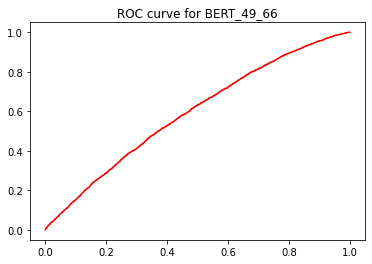

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

tf.get_logger().setLevel('WARNING')

def plot_model(name, model_url):
    model_path = os.path.join('trained_models', name, 'model')
    loaded_model = create_model(model_url)
    loaded_model.load_weights(model_path).expect_partial()
    model_preds = loaded_model.predict(test_x[1], batch_size=32, verbose=1).squeeze()
    p = np.where(model_preds > 0.5, 1, 0)
    accuracy = np.count_nonzero(p == test_y) / len(test_y) * 100
    num_negative = len(test_y[test_y == 0])
    num_positive = len(test_y[test_y == 1])
    negative_accuracy = np.count_nonzero((p == test_y) & (test_y == 0)) / num_negative * 100
    positive_accuracy = np.count_nonzero((p == test_y) & (test_y == 1)) / num_positive * 100
    print(f'Overall accuracy with threshold of 0.5: {accuracy}%')
    print(f'  Accuracy on positives: {positive_accuracy}%')
    print(f'  Accuracy on negatives: {negative_accuracy}%')
    fpr, tpr, threshold = roc_curve(test_y, model_preds)
    print(f'  AuC: {auc(fpr, tpr)}')
    plt.plot(fpr, tpr, color='red')
    plt.title(f'ROC curve for {name}')

plot_model('BERT_49_66', MED_MODEL_URL)

951/951 [==============================] - 121s 127ms/step
Overall accuracy with threshold of 0.5: 63.58318819624726%
  Accuracy on positives: 43.99497487437186%
  Accuracy on negatives: 66.5305659521379%
  AuC: 0.5844798878137997


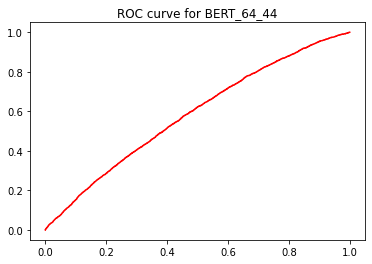

In [20]:
plot_model('BERT_64_44', SMALL_MODEL_URL)

951/951 [==============================] - 120s 126ms/step
Overall accuracy with threshold of 0.5: 68.28562978541619%
  Accuracy on positives: 34.22110552763819%
  Accuracy on negatives: 73.411213186647%
  AuC: 0.5583672397753008


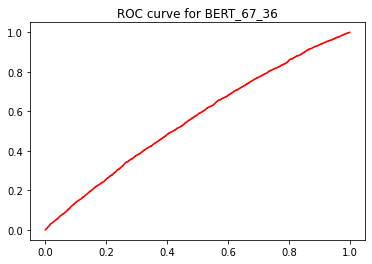

In [21]:
plot_model('BERT_67_36', SMALL_MODEL_URL)

951/951 [==============================] - 121s 127ms/step
Overall accuracy with threshold of 0.5: 79.50445269626368%
  Accuracy on positives: 15.100502512562814%
  Accuracy on negatives: 89.19511549657858%
  AuC: 0.5659729453285102


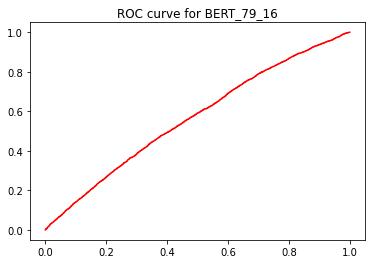

In [22]:
plot_model('BERT_79_16', SMALL_MODEL_URL)

951/951 [==============================] - 157s 165ms/step
Overall accuracy with threshold of 0.5: 83.00417337583386%
  Accuracy on positives: 10.175879396984925%
  Accuracy on negatives: 93.96242108048844%
  AuC: 0.5926425253179815


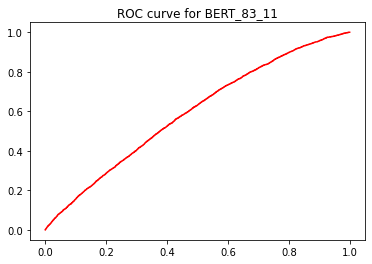

In [23]:
plot_model('BERT_83_11', MED_MODEL_URL)